<a href="https://colab.research.google.com/github/gdssouza/VSSF_prediction_with_SARIMA/blob/master/predict_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
#import time #helper libraries

In [2]:
#lendo dados
df = pd.read_csv("vss_xyz_dia_2017-2019",index_col=0)
#convertendo para datetime
df.DATE = pd.to_datetime(df.DATE)
#definindo DATA como index
df.set_index('DATE',inplace=True)
df.head()

,TIME,DOY,VSSX,VSSY,VSSZ,VSSG,F
DATE,,,,,,,
2017-01-01,00:00:00.000,1,16701.6,-6959.5,-14647.2,-0.3,23279.144113
2017-01-02,00:00:00.000,2,16714.7,-6967.7,-14644.2,-0.3,23289.109752
2017-01-03,00:00:00.000,3,16716.4,-6964.4,-14645.7,-0.2,23290.286061
2017-01-04,00:00:00.000,4,16710.7,-6959.6,-14647.0,-0.3,23285.577847
2017-01-05,00:00:00.000,5,16691.8,-6967.6,-14650.9,-0.4,23276.866366


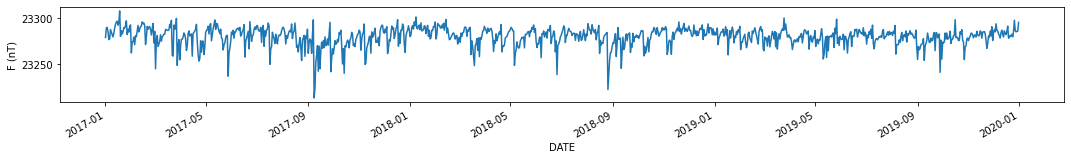

In [3]:
#visualizando
plt.figure(figsize=(18,9))

plt.subplot(4,1,1)
df.F.plot()
plt.ylabel("F (nT)")

plt.show()

### Predict

In [4]:
### Referência: https://github.com/omerbsezer/LSTM_RNN_Tutorials_with_Demo

In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [6]:
# fix random seed for reproducibility
np.random.seed(5)

In [7]:
# pegando a coluna com F
all_y = df.F.values
dataset = all_y.reshape(-1, 1)
# normalizando o dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_normalizado = scaler.fit_transform(dataset)

In [8]:
# separando dados de treino e dados de teste
train_size = int(len(dataset_normalizado)*0.6)
test_size = len(dataset_normalizado) - train_size
train, test = dataset_normalizado[0:train_size], dataset_normalizado[train_size:len(dataset)]

# reshape into X=t and Y=t+1, timestep 240
look_back = 240
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
# criando e treinando a LSTM, optimizer=adam, 25 neurons, dropout 0.1
model = Sequential()
model.add(LSTM(25, input_shape=(1, look_back)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=look_back, verbose=0)

In [10]:
# fazendo previsões
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict).reshape(1,-1)[0]

In [11]:
#separando dados para plotar
x_train = df.index.values[:train_size+look_back+1]
x_test = df.index.values[train_size+look_back+1:]
y_train = df.F.values[:train_size+look_back+1]
y_test = df.F.values[train_size+look_back+1:]

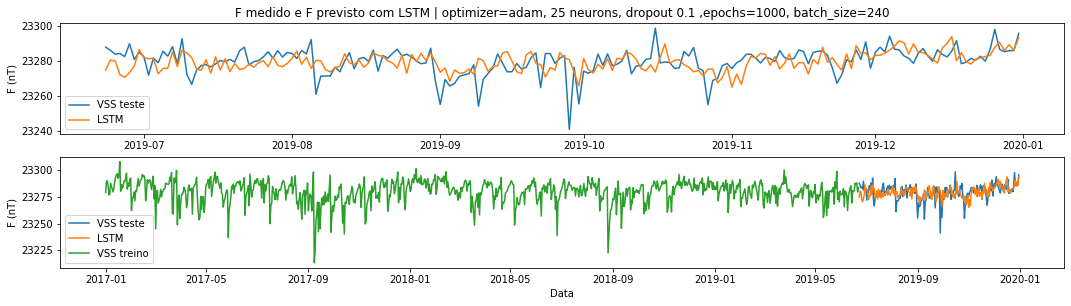

In [12]:
# visualizando resultado
plt.figure(figsize=(18,9/2))

plt.subplot(2,1,1)
plt.title("F medido e F previsto com LSTM | optimizer=adam, 25 neurons, dropout 0.1 ,epochs=1000, batch_size=240")
plt.plot(x_test,y_test)
plt.plot(x_test, testPredict)
plt.ylabel("F (nT)")
plt.legend(["VSS teste","LSTM"])

plt.subplot(2,1,2)
plt.plot(x_test,y_test)
plt.plot(x_test, testPredict)
plt.plot(x_train,y_train)
plt.ylabel("F (nT)")
plt.xlabel("Data")
plt.legend(["VSS teste","LSTM","VSS treino"])

plt.show()